In [1]:
# Setting the environment variables

In [2]:
import os
import sys
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook --no-browser"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

# Ecommerce Churn Assignment

The aim of the assignment is to build a model that predicts whether a person purchases an item after it has been added to the cart or not. Being a classification problem, you are expected to use your understanding of all the three models covered till now. You must select the most robust model and provide a solution that predicts the churn in the most suitable manner. 

For this assignment, you are provided the data associated with an e-commerce company for the month of October 2019. Your task is to first analyse the data, and then perform multiple steps towards the model building process.

The broad tasks are:
- Data Exploration
- Feature Engineering
- Model Selection
- Model Inference

### Data description

The dataset stores the information of a customer session on the e-commerce platform. It records the activity and the associated parameters with it.

- **event_time**: Date and time when user accesses the platform
- **event_type**: Action performed by the customer
            - View
            - Cart
            - Purchase
            - Remove from cart
- **product_id**: Unique number to identify the product in the event
- **category_id**: Unique number to identify the category of the product
- **category_code**: Stores primary and secondary categories of the product
- **brand**: Brand associated with the product
- **price**: Price of the product
- **user_id**: Unique ID for a customer
- **user_session**: Session ID for a user


### Initialising the SparkSession

The dataset provided is 5 GBs in size. Therefore, it is expected that you increase the driver memory to a greater number.

In [3]:
# Spark environment
from pyspark import SparkConf
from pyspark.sql import SparkSession

In [4]:
# initialising the session with 14 GB driver memory
MAX_MEMORY = "14G"

spark = SparkSession \
    .builder \
    .appName("demo") \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()

spark

In [5]:
# Spark session with 14 GB driver memory
spark.sparkContext.getConf().get('spark.driver.memory')

'14G'

In [42]:
#importing required libraries
import pandas as pd
from matplotlib import pyplot as plt
from pyspark.sql.functions import *

In [99]:
# loading the dataset from the EC2 instance - 2019-Oct.csv
df = spark.read.csv("2019-Oct.csv",header=True, inferSchema=True)

In [44]:
# exploring the dataframe - top 20 rows
df.show()

+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 00:00:...|      view|  44600062|2103807459595387724|                null|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|
|2019-10-01 00:00:...|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|   33.2|554748717|9333dfbd-b87a-470...|
|2019-10-01 00:00:...|      view|  17200506|2053013559792632471|furniture.living_...|    null|  543.1|519107250|566511c2-e2e3-422...|
|2019-10-01 00:00:...|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 00:00:...|      view|   1004237|205301355563188265

In [45]:
# exploring the dataframe - schema
df.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)



In [46]:
# Number of rows and columns in the dataset
row=df.count()
col=len(df.columns)
print(f"Dimension of the Dataframe is: {(row,col)}")

Dimension of the Dataframe is: (42448764, 9)


So, we have a huge dataset that contains 42 million rows.

Now, tha dataset is loaded in Spark environment. Let's proceed with the desired tasks.

<hr>

## Task 1 - Data Exploration

**Find**
- 5 most popular:
    - Products sold by the e-commerce company in the month
    - Brands on the platform
    - Product categories
- Number of unique users and the most active user on the platform
- Average and maximum price for smartphones purchased by the customers
<br>

**Plot and comment**
- Event-type funnel distribution in e-commerce shopping journey
- Traffic on different days of the week

Provide the results in a separate report.

In [47]:
# 5 most popular products sold
most=df.select("event_type","product_id")

In [48]:
most=most.filter("event_type == 'purchase' ")
most.groupby(["product_id"]).count().sort(desc("count")).show(5)

+----------+-----+
|product_id|count|
+----------+-----+
|   1004856|28944|
|   1004767|21806|
|   1004833|12697|
|   1005115|12543|
|   4804056|12381|
+----------+-----+
only showing top 5 rows



Product **1004856** is sold the most popular ut of all products

In [49]:
# 5 most popular brands
most=df.select("brand")
most.groupby(["brand"]).count().sort(desc("count")).show(6)

+-------+-------+
|  brand|  count|
+-------+-------+
|   null|6113008|
|samsung|5282775|
|  apple|4122554|
| xiaomi|3083763|
| huawei|1111205|
|lucente| 655861|
+-------+-------+
only showing top 6 rows



It is clear that most of the products sold on don't have a brand associated with them. Henace printing 6 rows to grt top 5.
<br>The five most popular brands are: Samsung, Apple, Xiaomi, Huawei, Lucente.It is clear that the most popular product is mobile phone.

In [50]:
#5 most popular product categories
most=df.select("category_code")
most.groupby(["category_code"]).count().sort(desc("count")).show(6)

+--------------------+--------+
|       category_code|   count|
+--------------------+--------+
|                null|13515609|
|electronics.smart...|11507231|
|  electronics.clocks| 1311033|
|  computers.notebook| 1137623|
|electronics.video.tv| 1113750|
|electronics.audio...| 1100188|
+--------------------+--------+
only showing top 6 rows



The top five category codes are printed above. As expected, smartphones are the most popular product category

In [51]:
# Number of unique users
df.select("user_id").distinct().count()

3022290

There are **3022290** unique active users on the platform.

In [52]:
# The most active user on the platform
au=df.select("user_id","user_session")
au.groupby("user_id").count().sort(desc("count")).show(1)

+---------+-----+
|  user_id|count|
+---------+-----+
|512475445| 7436|
+---------+-----+
only showing top 1 row



Most active user is **512475445**. He/She has registered 7436 user sessions

In [53]:
# Average and Maximum price for smartphones purchased by the customers
smart_ph=df.select("category_code", "price", "event_type")

In [54]:
smart_ph=smart_ph.filter("event_type == 'purchase' ")
smart_ph=smart_ph.filter("category_code == 'electronics.smartphone' ").toPandas()

In [55]:
print("Average price of purchased smartphone :", smart_ph.price.mean())
print("Maximum price of purchased smartphone :", smart_ph.price.max())

Average price of purchased smartphone : 464.61911309456883
Maximum price of purchased smartphone : 2110.45


The above result suggest the prices are not in rupees

In [56]:
# Event-type funnel distribution
# Remember Spark dataframe cannot be visualised directly
event=df.select("event_type","user_session")
funnel=event.groupby("event_type").count().toPandas()

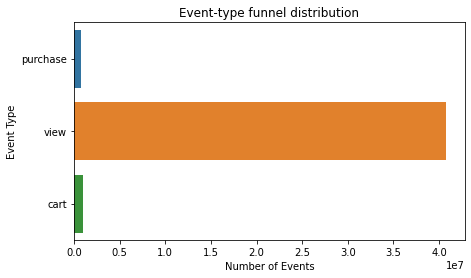

In [57]:
import seaborn as sns
plt.figure(figsize=(7,4))
sns.barplot(x="count", y="event_type", data=funnel)
plt.title('Event-type funnel distribution')
plt.xlabel('Number of Events')
plt.ylabel('Event Type')
plt.show()

The above plot clearly shows that many people view the items, but, only a few add the item to the cart and finally purchase it.

In [100]:
# Traffic on different days of the week
# Remember Spark dataframe cannot be visualised directly
df=df.withColumn('event_datetime', to_timestamp('event_time', 'yyyy-MM-dd HH:mm:ss'))

In [101]:
df=df.withColumn('event_day', dayofweek(df["event_datetime"]))

In [60]:
traffic=df.select("event_day","user_session")
traffic_week=traffic.groupby("event_day").count().toPandas()

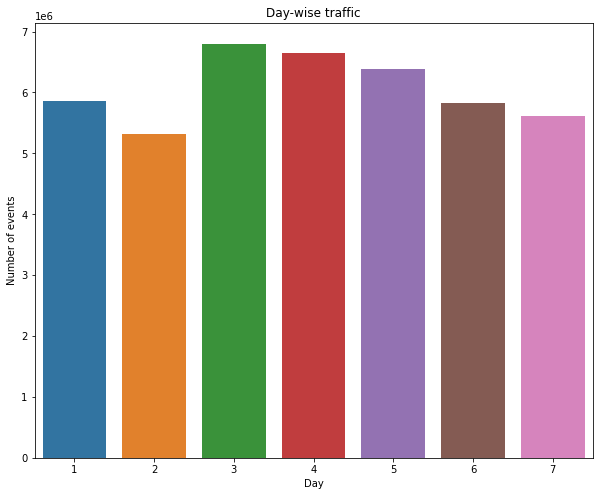

In [61]:
plt.figure(figsize=(10,8))
sns.barplot(x="event_day", y="count", data=traffic_week)
plt.title('Day-wise traffic')
plt.ylabel('Number of events')
plt.xlabel('Day')
plt.show()

As we can see that maximum traffic is on 3rd day of the week. we can find that it Tuesday.
<br> the expectation that the traffic will be more on weekends is not true according to this plot.

In [102]:
# drop redundant column(s), if any
df=df.drop("event_time")

In [103]:
df.columns

['event_type',
 'product_id',
 'category_id',
 'category_code',
 'brand',
 'price',
 'user_id',
 'user_session',
 'event_datetime',
 'event_day']

<hr>

## Task 2 - Feature Engineering

- Handle missing values (provide justification for approach)
- Generate the category code at 2 levels (Split into 2 columns)
    - Example: electronics.video.tv - electronics, video
- Capture user activity in different columns
    - Total activities (view/cart/etc.) in the session
    - Affinity towards a particular product (Product count for user)
    - Affinity towards a category (Secondary category count for user)
    - Average shopping expense for a product category (secondary)
    - Number of user sessions
- Impact of time: Day and Hour (Binning hours into 4 buckets)
- Reduction in brands for analysis: Top 20 + ‘others’
- Target variable generation: is_purchased


In [64]:
# Handling missing values 
#checking missing values
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+----------+----------+-----------+-------------+-------+-----+-------+------------+--------------+---------+
|event_type|product_id|category_id|category_code|  brand|price|user_id|user_session|event_datetime|event_day|
+----------+----------+-----------+-------------+-------+-----+-------+------------+--------------+---------+
|         0|         0|          0|     13515609|6113008|    0|      0|           2|             0|        0|
+----------+----------+-----------+-------------+-------+-----+-------+------------+--------------+---------+



The null values are of mainly in category and brand columns . Also, there is no other column to identify them and thus to impute values. Hence, we will drop the null values.
Eventhough roduct_id can be checked to identify some, we have a huge amount of data since dropping wont affect much. 

In [104]:
# Dropping the null values
df = df.na.drop()

In [66]:
#rechecking null values
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+----------+----------+-----------+-------------+-----+-----+-------+------------+--------------+---------+
|event_type|product_id|category_id|category_code|brand|price|user_id|user_session|event_datetime|event_day|
+----------+----------+-----------+-------------+-----+-----+-------+------------+--------------+---------+
|         0|         0|          0|            0|    0|    0|      0|           0|             0|        0|
+----------+----------+-----------+-------------+-----+-----+-------+------------+--------------+---------+



In [105]:
# Dropping duplicates\
df=df.dropDuplicates()

In [106]:
# drop redundant column(s), if any
df=df.drop("category_id")

In [108]:
# Generating 2 columns from category code
# Columns have only single entity (electronics.video.tv: electronics, video)
# Check if split command works with '.' or Spark treats it as special character
from pyspark.sql.functions import split,col
df = df.withColumn('category_1', split(col("category_code"), "\.")\
                   .getItem(0)).withColumn('category_2', split(col("category_code"), "\.").getItem(1))

In [109]:
# Check if the column is added
df.columns

['event_type',
 'product_id',
 'category_code',
 'brand',
 'price',
 'user_id',
 'user_session',
 'event_datetime',
 'event_day',
 'category_1',
 'category_2']

In [110]:
# Activities in a session by the user
# Window functions can be helpful here
from pyspark.sql import Window

In [111]:
# Activities in a session by the user
w = Window.partitionBy("user_session")
df = df.withColumn("user_activity_count", count("user_session").over(w))

In [112]:
# View count for a product by the user
# Window functions can be helpful here
w = Window.partitionBy("user_id","product_id")
df = df.withColumn("user_product", count("user_id").over(w))

In [113]:
# View count for the secondary category by the user
# Window functions can be helpful here
w = Window.partitionBy("user_id","category_2")
df = df.withColumn("user_category_2", count("user_id").over(w))

In [114]:
# Average shopping expense for a product category
# Window functions can be helpful here
w = Window.partitionBy("user_id","category_2")
df = df.withColumn("user_mean_spend", avg("price").over(w))

In [115]:
# Session count for a user
# Window functions can be helpful here
w = Window.partitionBy("user_id")
df = df.withColumn("user_session_count", approx_count_distinct("user_session").over(w))

In [116]:
# Generating the hour variable
df = df.withColumn("hour", hour(df["event_datetime"]))

In [117]:
# Binning the hour variable
df = df.withColumn("hour_bin", when(col("hour").between(0,5),1).when(col("hour").between(6,12),2).when(col("hour").between(13,18),3).otherwise(4))

In [118]:
# Check for the columns
df.columns

['event_type',
 'product_id',
 'category_code',
 'brand',
 'price',
 'user_id',
 'user_session',
 'event_datetime',
 'event_day',
 'category_1',
 'category_2',
 'user_activity_count',
 'user_product',
 'user_category_2',
 'user_mean_spend',
 'user_session_count',
 'hour',
 'hour_bin']

In [119]:
# Reduction in brands for analysis: Top 20 + ‘others'
brand_ds=df.select("brand")
brand_ds=brand_ds.groupby("brand").count().sort(desc("count"))

In [123]:
bd_df=brand_ds.toPandas()

In [125]:
elements = list(bd_df["brand"][20:])

In [126]:
df = df.replace(elements, 'others', subset=["brand"])

In [127]:
df.groupby("brand").count().sort(desc("count")).show()

+--------+-------+
|   brand|  count|
+--------+-------+
|  others|8880932|
| samsung|5147344|
|   apple|4087084|
|  xiaomi|2695456|
|  huawei|1090907|
|      lg| 508504|
|    oppo| 482131|
|    acer| 427810|
|  lenovo| 337854|
|   bosch| 329665|
|      hp| 294927|
| indesit| 289681|
| respect| 255502|
|   casio| 253547|
|   artel| 237098|
|    sony| 221161|
|elenberg| 217987|
|    asus| 211622|
|    beko| 206664|
|   haier| 180166|
+--------+-------+
only showing top 20 rows



In [128]:
# Generating 'is_purchased' variable
df = df.withColumn('is_purchased', when(df['event_type']=='purchase',1).otherwise(0))

# The column has been creaeted with the name as 'label' in this case
w = Window.partitionBy("user_id","product_id")
df = df.withColumn("label", max("is_purchased").over(w))

In [129]:
# Dropping redundant rows
df = df.filter(df.event_type=='cart')

In [130]:
# Printing the count by label
df.groupBy('label').count().show()

+-----+------+
|label| count|
+-----+------+
|    1|486047|
|    0|298314|
+-----+------+



In [131]:
# Printing the top 20 rows as output
df.show()

+----------+----------+--------------------+--------+-------+---------+--------------------+-------------------+---------+-----------+----------+-------------------+------------+---------------+------------------+------------------+----+--------+------------+-----+
|event_type|product_id|       category_code|   brand|  price|  user_id|        user_session|     event_datetime|event_day| category_1|category_2|user_activity_count|user_product|user_category_2|   user_mean_spend|user_session_count|hour|hour_bin|is_purchased|label|
+----------+----------+--------------------+--------+-------+---------+--------------------+-------------------+---------+-----------+----------+-------------------+------------+---------------+------------------+------------------+----+--------+------------+-----+
|      cart|   1004870|electronics.smart...| samsung| 283.62|454388908|a45905b4-f628-4df...|2019-10-22 10:26:12|        3|electronics|smartphone|                  2|           2|              3| 270.463

In [132]:
# Dropping the redundant columns 
df = df.drop('event_type', 'product_id', 'category_code', 'user_id', 'user_session', 'event_datetime', 'category_1', 'hour', 'is_purchased')

In [133]:
# Columns in df after feature engineering
df.columns

['brand',
 'price',
 'event_day',
 'category_2',
 'user_activity_count',
 'user_product',
 'user_category_2',
 'user_mean_spend',
 'user_session_count',
 'hour_bin',
 'label']

In [134]:
# Storing the cleaned df in the instance to prevent repetition of steps again
# Rename the file based on your preferences
df.coalesce(1).write.option("header", "true").parquet("cleaned_df.parquet")

Proceed to another notebooks after saving the dataframe.